<a href="https://colab.research.google.com/github/kisBelus/Machine-Learning/blob/master/HW_4/Homework_4_Problem_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 17:48:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.80, 2607:f8b0:4007:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   249MB/s    in 0.3s    

2020-04-19 17:48:26 (249 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base

In [5]:
from keras.applications import ResNet50V2

conv_base = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


94674944/94668760 [==============================] - 2s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 36,680,617
Trainable params: 13,115,817
Non-trainable params: 23,564,800
_________________________________

## Train the model end to end with frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 303ms/step - loss: 0.4831 - acc: 0.7330 - val_loss: 0.0135 - val_acc: 0.9590
Epoch 2/30
100/100 [==============================] - 20s 204ms/step - loss: 0.3728 - acc: 0.8235 - val_loss: 0.1777 - val_acc: 0.9530
Epoch 3/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3563 - acc: 0.8395 - val_loss: 0.7959 - val_acc: 0.9570
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3187 - acc: 0.8615 - val_loss: 0.0543 - val_acc: 0.9580
Epoch 5/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3088 - acc: 0.8615 - val_loss: 1.2267e-05 - val_acc: 0.9590
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.2934 - acc: 0.8760 - val_loss: 0.0206 - val_acc: 0.9570
Epoch 7/30
100/100 [==============================] - 20s 201ms/step - loss: 0.2737 - acc: 0.8835 - va

## Display curves of loss and accuracy during training

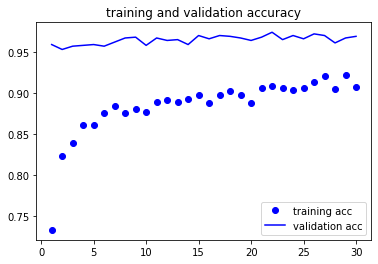

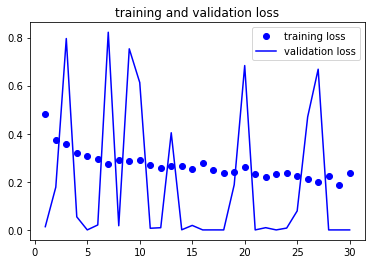

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [11]:
for layer in conv_base.layers:
  print(layer.name)

input_1
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d_1
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_block2_p

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [13]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 271ms/step - loss: 0.2116 - acc: 0.9090 - val_loss: 1.0638 - val_acc: 0.9420
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.1999 - acc: 0.9260 - val_loss: 0.2144 - val_acc: 0.9400
Epoch 3/100
100/100 [==============================] - 22s 218ms/step - loss: 0.1722 - acc: 0.9310 - val_loss: 0.2417 - val_acc: 0.9370
Epoch 4/100
100/100 [==============================] - 22s 217ms/step - loss: 0.1667 - acc: 0.9295 - val_loss: 0.2850 - val_acc: 0.9410
Epoch 5/100
100/100 [==============================] - 22s 216ms/step - loss: 0.1645 - acc: 0.9305 - val_loss: 0.2534 - val_acc: 0.9460
Epoch 6/100
100/100 [==============================] - 21s 214ms/step - loss: 0.1665 - acc: 0.9335 - val_loss: 0.1002 - val_acc: 0.9470
Epoch 7/100
100/100 [==============================] - 22s 215ms/step - loss: 0.1773 - acc: 0.9330 - val_loss: 0.0209 - val_acc: 0.9450
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

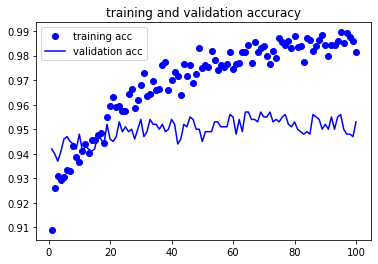

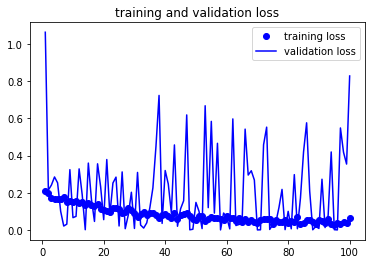

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [16]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.011346681043505669
Validation accuracy: 0.953000009059906


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [18]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

KeyboardInterrupt: ignored